# Deep Painterly Harmonization

A PyTorch implementation of the [Deep Painterly Harmonization](https://arxiv.org/abs/1804.03189) paper by  Fujun Luan, et al.

The authors of the paper published their code based on torch [here](https://github.com/luanfujun/deep-painterly-harmonization). My PyTorch implementation is inspired by it.

## Initial setup

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Import libraries.

In [2]:
from fastai.conv_learner import *

## Download dataset

You can download the data [here](https://github.com/luanfujun/deep-painterly-harmonization/tree/master/data).

Setup directories and files path.

 Make the `PATH` variable point to the download data.

In [10]:
PATH = Path('../../../data/wikiart')

We will focus on this example of painting for this notebook:

![Captain America](https://raw.githubusercontent.com/luanfujun/deep-painterly-harmonization/master/data/16_target.jpg)

## Data pipeline

Each example has 4 images associated to it:
- the style image (which is the painting)
- the input (our object superimposed on the painting)
- the mask that allows us to know where we added the object
- the dilated version of the mask

In [16]:
index = 16

style_img = open_image(PATH / f'{index}_target.jpg')
input_img = open_image(PATH / f'{index}_naive.jpg')
mask = open_image(PATH / f'{index}_c_mask.jpg')
dilated_mask = open_image(PATH / f'{index}_c_mask_dilated.jpg')

Plot and show images.

(-0.5, 699.5, 556.5, -0.5)

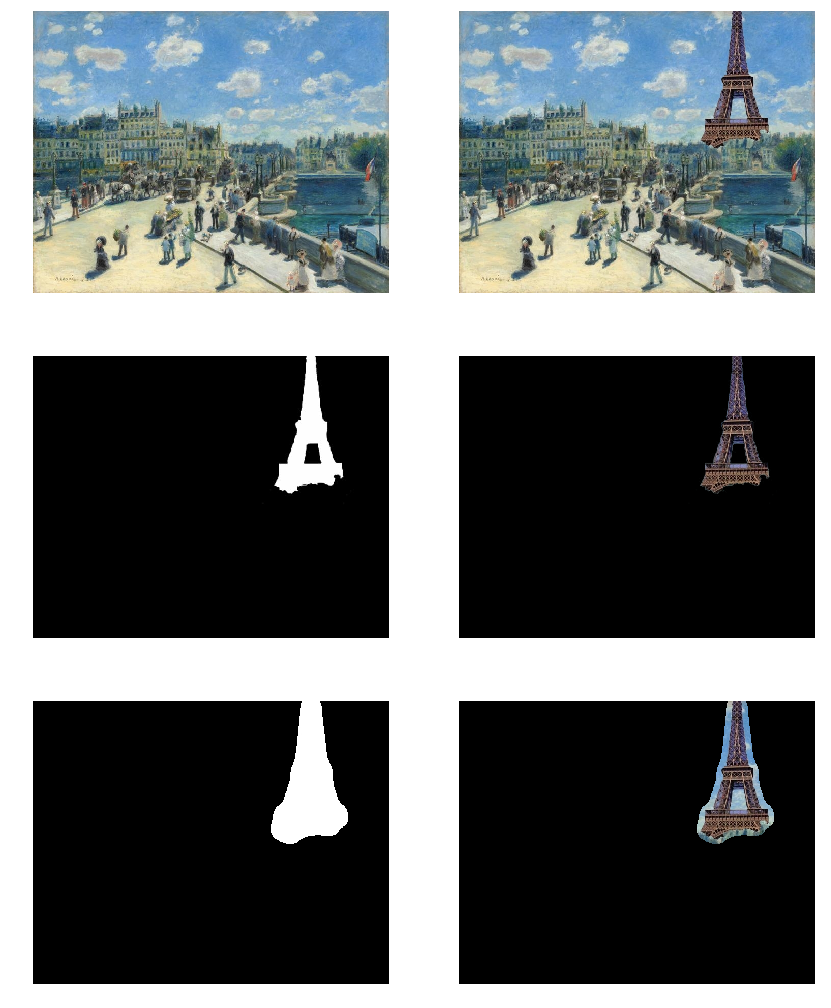

In [52]:
fig, ax = plt.subplots(3, 2, figsize=(14, 18))

ax[0][0].imshow(style_img)
ax[0][0].axis('off')

ax[0][1].imshow(input_img)
ax[0][1].axis('off')

ax[1][0].imshow(mask)
ax[1][0].axis('off')

ax[1][1].imshow(input_img * mask)
ax[1][1].axis('off')

ax[2][0].imshow(dilated_mask)
ax[2][0].axis('off')

ax[2][1].imshow(input_img * dilated_mask)
ax[2][1].axis('off')

Create a slightly enlarged version of our normal mask.

In [63]:
enlarge_mask = cv2.GaussianBlur(mask, (3, 3), 1)

Prepare our images ready for the model.

In [80]:
# Normalize the input and style image for VGG16 model.
trn_tfms, val_tfms = tfms_from_model(vgg16, 500, crop_type=CropType.NO)

In [81]:
print(val_tfms.tfms)

# Keep the image at their specific size. So, removes the scale transform.
val_tfms.tfms = val_tfms.tfms[2:]
val_tfms

[<fastai.transforms.Scale object at 0x7f43e56eaeb8>, <fastai.transforms.NoCrop object at 0x7f43e5642d30>, <fastai.transforms.Normalize object at 0x7f43e56ea3c8>, <fastai.transforms.ChannelOrder object at 0x7f43e5642c50>]


[<fastai.transforms.Normalize object at 0x7f43e56ea3c8>, <fastai.transforms.ChannelOrder object at 0x7f43e5642c50>]

In [82]:
# Transformed style image
style_tfm = val_tfms(style_img)

# Transformed input image
input_tfm = val_tfms(input_img)

## Model

We will use VGG16 network architecture.

We employed pre-trained VGG-16 as the feature extractor.

In the two steps of the algorithm, we will only use the VGG activations of layer 36, so I've freezed the layers we don't use by setting it to not trainable so we don't waste time and memory calculating gradients for it.

In [83]:
layers = cut_model(vgg16(True), 37)
vgg_model = to_gpu(nn.Sequential(*layers)).eval()
set_trainable(vgg_model, False)

In [85]:
vgg_model = to_gpu(vgg16(True)).eval()
set_trainable(vgg_model, False)

In [86]:
vgg_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

We will use the activations of `conv1_1`, `conv2_1`, `conv3_1`, `conv4_1` and `conv5_1` during the two steps of the process. The layer indexes are 2, 9, 16, 26 and 36.

## First Pass: Robust Coarse Harmonization

From the paper, for the first-pass optimization, they chose `conv4_1` as the content representation, and `conv3_1`, `conv4_1` and `conv5_1` as the style representation, since higher layers have been transformed by the CNN into representations with more of the actual content, which is crucial for the semantic-aware nearest-neighbor search.

In [87]:
index_layers = [16, 26, 36]

So rather than lopping off all of the layers after the one we want, it be nice if we could somehow grab the activations of a few layers as it calculates. PyTorch has these fantastic things called **hooks**. You can have forward hooks that let you plug anything you like into the forward pass of a calculation or a backward hook that lets you plug anything you like into the backward pass.

In [91]:
class SaveFeatures(nn.Module):
    features = None

    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output

    def close(self):
        self.hook.remove()

We hook those chosen layers so every time we do a forward pass on the VGG model, it's going to store the 16th, 26th and 36th layer's output (activations) inside `sf.features`.

In [93]:
save_features = [SaveFeatures(children(vgg_model)[index]) for index in index_layers]

Get the features for our input image and our style image.

In [97]:
# None is to add a batch dimension.
# VV is a util function that returns PyTorch Variable without require_grad.
inp_tfm_var = VV(input_tfm[None])
vgg_model(inp_tfm_var)
input_features = [s.features for s in save_features]
[ifs.shape for ifs in input_features]

[torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87]),
 torch.Size([1, 512, 34, 43])]

In [98]:
style_tfm_var = VV(style_tfm[None])
vgg_model(style_tfm_var)
style_features = [s.features for s in save_features]
[sfs.shape for sfs in style_features]

[torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87]),
 torch.Size([1, 512, 34, 43])]

Next, make a forward pass through the conv net with our mask to get its corresponding features.

The authors half the mask dimension at each max pooling, then pass it through a `nn.AvgPool2d(3, 1, 1)` (3 by 3, stride 1, padding 1 average pooling) at each convolutional layer.

In [99]:
ConvMask = nn.AvgPool2d(3, 1, 1)

def conv(mask, n):
    x = V(mask[None][None])

    for i in range(n):
        x = ConvMask(x)

    return to_np(x.data.squeeze())

In [100]:
def resize_half(mask):
    h, w = mask.shape
    return cv2.resize(mask, (w//2, h//2))

In [101]:
def get_mask_features(mask):
    features = []

    mask = resize_half(conv(mask, 2))
    mask = resize_half(conv(mask, 2))
    mask = conv(mask, 1)
    features.append(mask)

    mask = resize_half(conv(mask, 2))
    mask = conv(mask, 1)
    features.append(mask)

    mask = resize_half(conv(mask, 2))
    mask = conv(mask, 1)
    features.append(mask)

    return features

In [102]:
mask_features = get_mask_features(dilated_mask[:, :, 0])
[mfs.shape for mfs in mask_features]

[(139, 175), (69, 87), (34, 43)]

### Mapping

The first pass is based on Leon Gatys's neural style transfer idea.

We are going to map every pixel of the content features to one in the style features.

In [105]:
def arr2vec(x, kernel_size=3, stride=1, padding=1):
    """
    A vectorization function to get all the possible patches in a big array.
    """
    ch, n1, n2 = x.shape
    y = np.zeros((ch, n1+2*padding, n2+2*padding))
    y[:, padding:n1+padding, padding:n2+padding] = x
    start_index = np.array([j + (n2+2*padding)*i
                            for i in range(0, n1-kernel_size+1+2*padding, stride)
                                for j in range(0, n2-kernel_size+1+2*padding, stride)])
    grid = np.array([j + (n2+2*padding)*i + (n1+2*padding) * (n2+2*padding) * k
                     for k in range(0, ch)
                         for i in range(kernel_size)
                             for j in range(kernel_size)])
    to_take = start_index[:, None] + grid[None, :]
    return y.take(to_take)

Compute the cosine similarities and get the mapping.

In [109]:
def map_features(input_feats, style_feats):
    mapping = []

    for inp, sty in zip(input_feats, style_feats):
        inp_var = VV(arr2vec(to_np(inp[0].data)))
        sty_var = VV(arr2vec(to_np(sty[0].data)))
        scalars = torch.mm(inp_var, sty_var.t())
        norms_inp = torch.sqrt((inp_var ** 2).sum(1))
        norms_sty = torch.sqrt((sty_var ** 2).sum(1))
        cosine_sim = scalars / (1e-15 + norms_inp.unsqueeze(1) * norms_sty.unsqueeze(0))
        _, index_max = cosine_sim.max(1)
        mapping.append(to_np(index_max))

    return mapping

In [110]:
mappings = map_features(input_features, style_features)

Then we use this mappings to re-map the style features.

In [119]:
def remap_style(style_feats, mp):
    out = []
    for sty, maps in zip(style_feats, mp):
        sty = to_np(sty).reshape(sty.size(1), -1)
        sty = sty[:, maps]
        out.append(VV(sty))
    return out

In [120]:
remap_style_features = remap_style(style_features, mappings)

### Reconstruction

In our case, we are not optimizing weights, we are optimizing pixels.

We will optimize the pixels in our input image (the one with object superimposed on the painting).

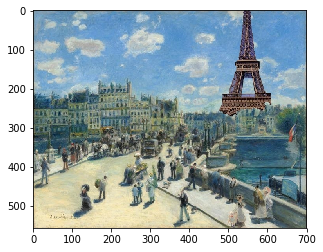

In [113]:
# input_tfm is our VGG16 normalized input image
optimize_img = input_tfm.copy()

# Denormalize image so that we can show it
plt.imshow(val_tfms.denorm(to_np(optimize_img).transpose(1, 2, 0)))

In [114]:
optimize_img_var = V(optimize_img[None], requires_grad=True)
optimize_img_var.shape

torch.Size([1, 3, 557, 700])

Optimizer and step function for the training:

In [116]:
# learning rate is set to 1 in their code for this stage (first pass)
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([optimize_img_var], lr=1)

In [133]:
def step(loss_fn):
    global n_iter

    optimizer.zero_grad()
    loss = loss_fn(optimize_img_var)
    loss.backward()
    n_iter += 1

    if n_iter % show_iter == 0:
        print(f'Iteration: {n_iter}, loss: {loss.data[0]}')

    return loss

Loss functions

Content loss is the MSE loss of the content and input features from the fourth convolutional layers (stored at index 1). We apply the corresponding mask to both of them before taking this loss.

In [127]:
def content_loss(out_feats):
    out_mask_feats = out_feats * V(mask_features[1][None,None], requires_grad=False)
    in_mask_feats = input_features[1] * V(mask_features[1][None,None], requires_grad=False)
    return F.mse_loss(out_mask_feats, in_mask_feats, size_average=False) / float(out_feats.size(1) * mask_features[1].sum())

For the style loss, we compute the gram matrix and the MSE loss of two gram matrices.

In [128]:
def gram(input):
    x = input
    return torch.mm(x, x.t())

def gram_mse_loss(input, target):
    return F.mse_loss(gram(input), gram(target))

Then we apply the mask before taking this loss, for all the layers (conv 3, 4 and 5), with the input features and the remapped style features.

In [140]:
def style_loss(out_feats):
    loss = 0

    for outf, mapstyf, maskf in zip(out_feats, remap_style_features, mask_features):
        inp_gram_mx = outf * V(maskf[None, None], requires_grad=False)
        inp_gram_mx = inp_gram_mx.view(inp_gram_mx.size(1), -1)
        mapsty_gram_mx = mapstyf * V(maskf, requires_grad=False).view(1, -1)
        loss += gram_mse_loss(inp_gram_mx, mapsty_gram_mx)

    return loss / 3

The weights for first pass (stage 1).

In [130]:
wgt_cnt, wgt_sty = 1, 10

First pass (stage 1) loss.

In [136]:
def first_pass_loss(opt_img_var):
    vgg_model(opt_img_var)
    out_feats = [o.features for o in save_features]
    cnt_loss = content_loss(out_feats[1])
    sty_loss = style_loss(out_feats)

    return wgt_cnt * cnt_loss + wgt_sty * sty_loss

### Training

Finally, we can start training.

In [141]:
n_iter = 0

while n_iter <= max_iter:
    optimizer.step(partial(step, first_pass_loss))

Iteration: 100, loss: 1.0574499368667603
Iteration: 200, loss: 0.6704603433609009
Iteration: 300, loss: 0.5368689298629761
Iteration: 400, loss: 0.47422587871551514
Iteration: 500, loss: 0.43755385279655457
Iteration: 600, loss: 0.4115983247756958
Iteration: 700, loss: 0.39384791254997253
Iteration: 800, loss: 0.3807651102542877
Iteration: 900, loss: 0.3704095184803009
Iteration: 1000, loss: 0.362394779920578


Check the result!

(-0.5, 699.5, 556.5, -0.5)

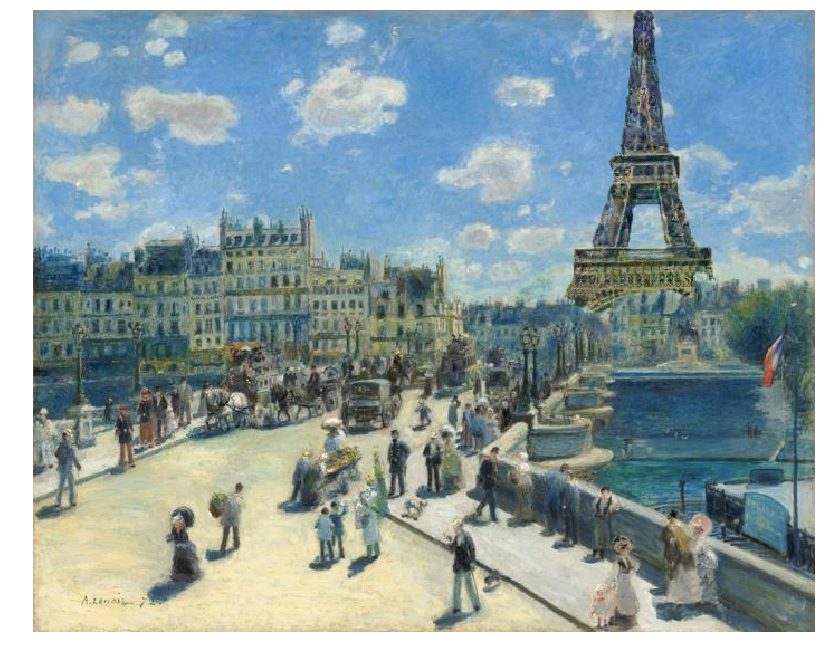

In [144]:
fig, ax = plt.subplots(1,1, figsize=(14, 14))
output_img = val_tfms.denorm(to_np(optimize_img_var.data)[0].transpose(1, 2, 0))
output_img = output_img * enlarge_mask + style_img * (1 - enlarge_mask)
output_img = output_img.clip(0, 1)
ax.imshow(output_img)
ax.axis('off')

Save our work for the second pass.

In [149]:
np.save(PATH / f'first_pass_output_img_for_painting{index}.npy', output_img)

## Second Pass: High-Quality Refinement

As can be seen in the image above, the results after the first pass match the desired style but suffer from artifacts.

Let's start the second pass optimization. First, get the first pass output image from the previous saved result.

In [150]:
first_pass_img = np.load(PATH / f'first_pass_output_img_for_painting{index}.npy')
first_pass_tfm = val_tfms(first_pass_img)

From the paper, for the second-pass optimization, the authors chose `conv4_1` as the content representation, `conv1_1`, `conv2_1`, `conv3_1` and `conv4_1` as the style representation. They
also employed the histogram loss and used `conv1_1`, and `conv4_1` as the histogram representation. They chose `conv4_1` as the reference layer for the nearest-neighbor search.

Those are the activation of layers 2, 9, 16 and 26.

In [152]:
index_layers = [2, 9, 16, 26]

In [153]:
save_features = [SaveFeatures(children(vgg_model)[index]) for index in index_layers]

Use the features of the original input image, `input_tfm` for the content loss.

In [154]:
inp_tfm_var = VV(input_tfm[None])
vgg_model(inp_tfm_var)
input_features = [s.features for s in save_features]
[ifs.shape for ifs in input_features]

[torch.Size([1, 64, 557, 700]),
 torch.Size([1, 128, 278, 350]),
 torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87])]

For the matching in the style loss, we will use the features of the first pass image.

In [155]:
first_pass_tfm_var = VV(first_pass_tfm[None])
vgg_model(first_pass_tfm_var)
first_pass_features = [s.features for s in save_features]
[fpfs.shape for fpfs in first_pass_features]

[torch.Size([1, 64, 557, 700]),
 torch.Size([1, 128, 278, 350]),
 torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87])]

We will use the features of the style image, `style_tfm` in the style loss and histogram loss.

In [156]:
style_tfm_var = VV(style_tfm[None])
vgg_model(style_tfm_var)
style_features = [s.features for s in save_features]
[sf.shape for sf in style_features]

[torch.Size([1, 64, 557, 700]),
 torch.Size([1, 128, 278, 350]),
 torch.Size([1, 256, 139, 175]),
 torch.Size([1, 512, 69, 87])]

Make a forward pass with our mask through the conv net.

In [157]:
def get_mask_features_sec_pass(mask):
    features = []
    
    mask = conv(mask, 1)
    features.append(mask)
    
    mask = resize_half(conv(mask, 1))
    mask = conv(mask, 1)
    features.append(mask)
    
    mask = resize_half(conv(mask, 1))
    mask = conv(mask, 1)
    features.append(mask)
    
    mask = resize_half(conv(mask, 2))
    mask = conv(mask, 1)
    features.append(mask)
    
    return features

In [158]:
mask_features = get_mask_features_sec_pass(dilated_mask[:, :, 0])
[mfs.shape for mfs in mask_features]

[(557, 700), (278, 350), (139, 175), (69, 87)]

### Mapping

We start the first map which is similar to the first pass.

In [159]:
def map_features_sec_pass(input_feats, style_feats):
    inp_var = VV(arr2vec(to_np(input_feats[0].data)))
    sty_var = VV(arr2vec(to_np(style_feats[0].data)))
    scalars = torch.mm(inp_var, sty_var.t())
    norms_inp = torch.sqrt((inp_var ** 2).sum(1))
    norms_sty = torch.sqrt((sty_var ** 2).sum(1))
    cosine_sim = scalars / (1e-15 + norms_inp.unsqueeze(1) * norms_sty.unsqueeze(0))
    _, index_max = cosine_sim.max(1)
    return to_np(index_max)

In [162]:
first_mappings = map_features_sec_pass(first_pass_features[-1], style_features[-1])

**Nearest-neighbour search**

Calculate neighbour index.

In [165]:
def calc_neighbour(index, nbr, size):
    """
    Returns the index of the neighbour (`nbr`)
    """
    n1, n2 = size
    coords = np.array([index // n2, index % n2]) + nbr
    
    if coords[0] >= 0 and coords[0] < n1 and coords[1] >= 0 and coords[1] < n2:
        return coords[0] * n2 + coords[1]
    else:
        return -1

In [166]:
def second_map(first_map, style_feats, mask, ks=5):
    # Generate neighbours array coords
    window_size = 5 # 5 comes from the authors' code.
    n_rad = window_size // 2
    neighbours = [np.array([i, j])
                 for i in range(-n_rad, n_rad+1)
                     for j in range(-n_rad, n_rad+1)]

    ch, n1, n2 = style_feats.shape
    rad = (ks - 1) // 2
    style_feats = np.reshape(style_feats, (ch, n1 * n2)).transpose()
    mappings = first_map.copy()
    
    for i in range(n1 * n2):
        if mask[i] <= 0.1: continue
        candidates = []
        style_neighbours = []
        
        for ngb in neighbours:
            i1 = calc_neighbour(i, ngb, (n1, n2))
            if i1 != -1:
                j = calc_neighbour(first_map[i1], -ngb, (n1, n2))
                if j != -1:
                    candidates.append(j)
                    style_neighbours.append(j)

        candidates = list(set(candidates))

        candidate_feats = np.take(style_feats, candidates, axis=0)
        neighbour_feats = np.take(style_feats, style_neighbours, axis=0)
        distances = ((candidate_feats[:, None] - neighbour_feats[None, :]) ** 2).sum(axis=2).sum(axis=1)
        mappings[i] = candidates[distances.argmin()]

    return mappings

*From the paper, the authors mentioned that they used the features from the reference layer for this second mapping, but in their code, they use the style image.*

In [167]:
# Their code
sty_img_resized = cv2.resize(style_img, (style_features[-1].size(3), style_features[-1].size(2)))

t_mask = cv2.resize(mask, (style_features[-1].size(3), style_features[-1].size(2)),
                    interpolation=cv2.INTER_NEAREST)[:, :, 0] # t_mask is tight mask
sty_resized_tfm, _ = val_tfms(sty_img_resized, mask)
second_map = second_map(first_mappings, sty_resized_tfm, t_mask.reshape(-1))

We then upsample this spatially consistent map to the finer levels of the network, thereby ensuring that at each output location, the neural responses at all scales come from the same location in the painting.

In [168]:
def upsample(ref_map, ref_size, new_size):
    r_h, r_w = ref_size
    n_h, n_w = new_size
    new_map = np.zeros(n_h * n_w).astype(np.int32)
    ratio_h, ratio_w = n_h / r_h, n_w / r_w

    for i in range(n_h * n_w):
        n_x, n_y = i // n_w, i % n_w
        r_x, r_y = int((0.5 + n_x) / ratio_h), int((0.5 + n_y) / ratio_w)
        r_x, r_y = min(max(0, r_x), r_h - 1), min(max(0, r_y), r_w - 1)
        style_idx = ref_map[r_x * r_w + r_y]
        s_x = int(n_x + (style_idx // r_w - r_x) * ratio_h + 0.5)
        s_y = int(n_y + (style_idx % r_w - r_y) * ratio_w + 0.5)
        s_x, s_y = min(max(0, s_x), n_h - 1), min(max(0, s_y), n_w - 1)
        new_map[i] = s_x * n_w + s_y

    return new_map

In [169]:
map_features = [upsample(second_map, mask_features[-1].shape, mfs.shape)
            for mfs in mask_features[:-1]] + [second_map]

Resize the tight mask `t_mask` to all the other layers. It will be used on the style features for the style loss and the histogram loss. The dilated mask will also be used on the output features and for the content loss.

In [170]:
t_mask_features = [t_mask]

for sf in style_features[-2::-1]:
    resized_t_mask = cv2.resize(t_mask_features[0], (sf.size(3), sf.size(2)),
                                interpolation=cv2.INTER_NEAREST)
    t_mask_features.insert(0, resized_t_mask)

[tmf.shape for tmf in t_mask_features]

[(557, 700), (278, 350), (139, 175), (69, 87)]

Next, remap the style and also returns a mask that will cover the duplicate style features with a 0 to remove it.

In [171]:
def remap_style_sec_pass():
    out = []
    out_mask = []

    for sf, mapf, mf in zip(style_features, map_features, t_mask_features):
        sf = to_np(sf).reshape(sf.size(1),-1)
        msk = mf.copy().reshape(-1)
        sf = sf[:, mapf]
        cnt = Counter(mapf)

        for i,m in enumerate(mapf):
            if msk[i] >= 0.1 and cnt[m] > 1:
                mask = (mapf == m)
                mask[i] = False
                msk[mask] = 0
        out.append(VV(sf))
        out_mask.append(msk)
    return out, out_mask

In [172]:
remap_sty_features, t_mask_features = remap_style_sec_pass()

Calculate the histogram of the style features covered by its mask.

In [173]:
def calc_mask_histogram(style_feats, mask_feats, n_bins):
    mask_tsr = torch.Tensor(mask_feats).contiguous()
    masked = style_feats * mask_tsr
    return torch.cat([torch.histc(masked[i][mask_tsr >= 0.1], n_bins).unsqueeze(0)
                      for i in range(masked.size(0))]).cuda()

In [176]:
n_bins = 256

remap_sty_flattened = [remap_sty_features[0].data.cpu(), remap_sty_features[3].data.cpu()]
t_mask_hist = [t_mask_features[0], t_mask_features[3]]
sty_feats_hist = [calc_mask_histogram(rmsf, tmf, n_bins)
                  for rmsf, tmf in zip(remap_sty_flattened, t_mask_hist)]

### Loss functions

#### Content loss

As before, content loss is the same, except that the desired features are now at the index -1.

In [178]:
def content_loss(out_feats):
    out_mask_feats = out_feats * V(mask_features[-1][None,None], requires_grad=False)
    in_mask_feats = input_features[-1] * V(mask_features[-1][None,None], requires_grad=False)
    return F.mse_loss(out_mask_feats, in_mask_feats, size_average=False) / float(out_feats.size(-1) * mask_features[-1].sum())

#### Style loss

Gram matrices and Gram MSE loss as before.

In [179]:
def gram(input):
    x = input
    return torch.mm(x, x.t())

def gram_mse_loss(input, target):
    return F.mse_loss(gram(input), gram(target))

In [180]:
def style_loss(out_feats):
    loss = 0
    
    for of, rmsf, mf, tmf in zip(out_feats, remap_sty_features, mask_features, t_mask_features):
        inp_gram_mx = of * V(mf[None, None], requires_grad=False) 
        inp_gram_mx = inp_gram_mx.view(inp_gram_mx.size(1), -1)
        rmsf = rmsf * V(tmf[None], requires_grad=False).view(1, -1)
        rmsf = rmsf * float(np.sqrt(mf.sum() / tmf.sum())) # normalize the two masks
        loss += gram_mse_loss(inp_gram_mx, rmsf)

    return loss / 4

#### Histogram loss

[Histogram matching](https://en.wikipedia.org/wiki/Histogram_matching) is a technique that is used to modify a photograph with the illumination (such as shadows) of another.

In the paper, Pierre Wilmot et al. found that applying the same technique to define another loss could help preserve the textures of the style picture. They recommended to use it for the features of the first convolutional layer and the fourth one, for both the fine details and the more general aspects of the style.

The idea is, for these two layers, to compute the histogram of each channel of the style features as a reference. Then, at each pass of our training, we calculate the remapping of our output features so that their histogram (for each channel) matches the style reference.

We then define the histogram loss as being the the mean-squared error between the output features and their remapped version. The challenge here is to compute that remapping.

In [181]:
def remap_histogram(x, hist_ref):
    ch, n = x.size()
    sorted_x, sort_idx = x.data.sort(1)
    ymin, ymax = x.data.min(1)[0].unsqueeze(1), x.data.max(1)[0].unsqueeze(1)
    hist = hist_ref * n / hist_ref.sum(1).unsqueeze(1) #normalization between the different lengths of masks.
    cum_ref = hist.cumsum(1)
    cum_prev = torch.cat([torch.zeros(ch, 1).cuda(), cum_ref[:, :-1]], 1)
    step = (ymax - ymin) / n_bins
    rng = torch.arange(1, n + 1).unsqueeze(0).cuda()
    idx = (cum_ref.unsqueeze(1) - rng.unsqueeze(2) < 0).sum(2).long()
    ratio = (rng - select_index(cum_prev, idx)) / (1e-8 + select_index(hist, idx))
    ratio = ratio.squeeze().clamp(0, 1)
    new_x = ymin + (ratio + idx.float()) * step
    new_x[:, -1] = ymax
    _, remap = sort_idx.sort()
    new_x = select_index(new_x, idx)
    return new_x

In [199]:
# select an array of indexes in a tensor
def select_index(tensor, idx):
    ch = tensor.size(0)
    return tensor.view(-1)[idx.view(-1)].view(ch,-1)

In [182]:
def histogram_loss(out_feats):
    loss = 0

    mask_hist = [mask_features[0], mask_features[3]]

    for of, mf, sh in zip(out_feats, mask_hist, sty_feats_hist):
        of = of.view(of.size(1), -1)
        mask = V(torch.Tensor(mf).contiguous().view(1, -1), requires_grad=False)
        of_masked = of * mask
        of_masked = torch.cat([of_masked[i][mask >= 0.1].unsqueeze(0) for i in range(of_masked.size(0))])
        loss += F.mse_loss(of_masked, V(remap_histogram(of_masked, sh), requires_grad=False))
        
    return loss / 2

#### Total Variation loss

In the _Perceptual losses for real-time style transfer and super-resolution._ paper, Johnson et al. showed that the total variation loss improves style transfer results by producing smoother output.

In [185]:
def total_var_loss(out_feats):
    # the sum is over all the (x, y) pixels of the output image
    px_w_sum = ((out_feats[:, :-1, :] - out_feats[:, 1:, :]) ** 2).sum()
    px_h_sum = ((out_feats[:, :, :-1] - out_feats[:, :, 1:]) ** 2).sum()
    return px_w_sum + px_h_sum

This is to get the parameter used in computing the weight of the TV loss, `wgt_tv`.

In [186]:
def get_total_var_hyperparam(arr_im):
    ch, h, w = arr_im.shape
    arr_w = np.concatenate([np.zeros((ch, w))[:, None, :], arr_im], axis=1)
    arr_h = np.concatenate([np.zeros((ch, h))[:, :, None], arr_im], axis=2)
    px_w = (arr_w[:, :-1, :] - arr_w[:, 1:, :]) ** 2
    px_h = (arr_h[:, :, :-1] - arr_h[:, :, 1:]) ** 2
    return np.median(px_w + px_h)

In [188]:
tot_var = get_total_var_hyperparam(style_tfm) # pass in normalized style image

The weights for second pass (stage 2):

In [189]:
wgt_sty, wgt_histo = 0.01, 1
wgt_tot_var = float(10 / (1 + np.exp(tot_var * 10**4 -25)))

*Note that the formulas to compute the weight come from their code. You can find other parameters like `tau` from the text file in the data folder.*

#### Second pass (stage 2) loss

In [197]:
def second_pass_loss(optimize_img_var):
    vgg_model(optimize_img_var)

    out_feats = [o.features for o in save_features]
    cnt_loss = content_loss(out_feats[-1])
    sty_loss = style_loss(out_feats)
    hist_loss = histogram_loss([out_feats[0], out_feats[3]])
    totvar_loss = total_var_loss(optimize_img_var[0])

    return cnt_loss + wgt_sty * sty_loss + wgt_histo * hist_loss + wgt_tot_var * totvar_loss

### Reconstruction

We will optimize the pixels in our input image (the one with Eifel Tower object superimposed on the painting).

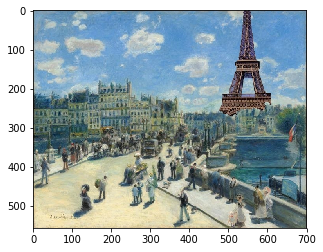

In [192]:
# input_tfm is our VGG16 normalized input image
optimize_img = input_tfm.copy()

# Denormalize image so that we can show it
plt.imshow(val_tfms.denorm(to_np(optimize_img).transpose(1, 2, 0)))

In [193]:
optimize_img_var = V(optimize_img[None], requires_grad=True)
optimize_img_var.shape

torch.Size([1, 3, 557, 700])

Optimizer and step function for the training:

In [194]:
# Learning rate is set to 0.1 in their code for this stage (second pass)
max_iter = 1000
show_iter = 100
optimizer = optim.LBFGS([optimize_img_var], lr=0.1)

In [195]:
def step(loss_fn):
    global n_iter
    
    optimizer.zero_grad()
    loss = loss_fn(optimize_img_var)
    loss.backward()
    n_iter += 1

    if n_iter % show_iter == 0:
        print(f'Iteration: {n_iter}, loss: {loss.data[0]}')

    return loss

#### Training

In [200]:
n_iter = 0

while n_iter <= max_iter:
    optimizer.step(partial(step, second_pass_loss))

Iteration: 100, loss: 0.09307822585105896
Iteration: 200, loss: 0.0523030087351799
Iteration: 300, loss: 0.045494429767131805
Iteration: 400, loss: 0.042685024440288544
Iteration: 500, loss: 0.04121791198849678
Iteration: 600, loss: 0.04031059890985489
Iteration: 700, loss: 0.039729561656713486
Iteration: 800, loss: 0.03930998593568802
Iteration: 900, loss: 0.038987234234809875
Iteration: 1000, loss: 0.03872665762901306


Training took ~23 min.

Check the result!

In [212]:
def show_img(img_var, figsize=(14, 14)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    output_img = val_tfms.denorm(to_np(img_var.data)[0].transpose(1, 2, 0))
    output_img = output_img * enlarge_mask + style_img * (1 - enlarge_mask)
    output_img = output_img.clip(0, 1)
    ax.imshow(output_img)
    ax.axis('off')
    
    return output_img

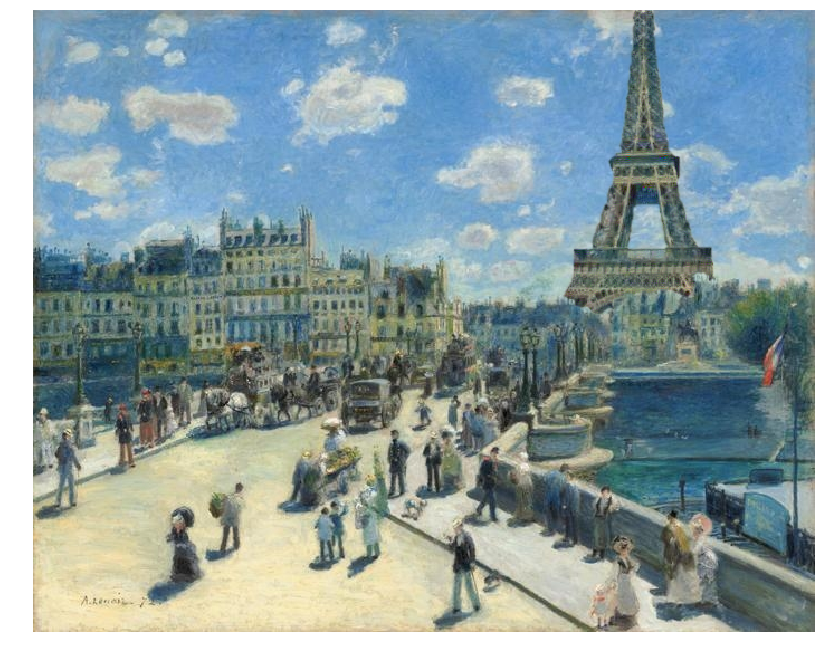

In [213]:
output_img = show_img(optimize_img_var, (14, 14))

Save work.

In [214]:
np.save(PATH / f'second_pass_output_img_for_painting{index}.npy', output_img)